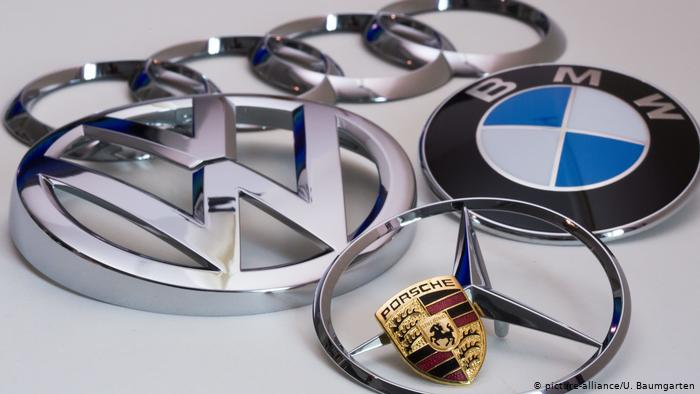

### Objective
The objective of this study is to examine the predictive effectiveness of the ARIMA model in Time Series Analysis. This study is applicable to Event-driven investment strategy that seeks to exploit pricing inefficiencies that may occur before or after a corporate event, such as an earnings call, bankruptcy, merger, acquisition, or spinoff. In more recent times market practitioners have expanded this definition to include additional events such as natural disasters and actions initiated by shareholder activists. However, merger arbitrage remains the most well-known investment strategy within this group. 

This is a case study analysis leading up to the acquisition buyout of Porsche by Volkswagen. A Comparison of the models that
best describes how events affected equity prices, returns, best fitting models and volatility trends.

### Data
The data were scraped from Yahoo Finance market data and the news events surrounding the merger of Volkswagen and Porsche, 
as well as, a key event in the diesel scandal. The symbols obtained from the German Stock Exchange are the following:

Volkswagen (VOW3.DE), Porsche (PAH3.DE), BMW (BMW.DE)

BMW (BMW.DE) will be used a benchmark from the German Stock Exchange from the Auto Industry.

### Models 
The following models were employed in the event-driven study and forecast:
- ARIMA
- SARIMAX
- GARCH


## Import Libraries

In [1]:
# data manipulation libraries
import numpy as np
import pandas as pd
import scipy

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning library
import sklearn

# statistical libraries
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model

# data import library from yahoo finance
import yfinance

# warning suppression library
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Import Data

In [2]:
# symbols are associated with the Frankfurt German Stock Exchange Deutsche Börse AG for:
# Volkswagen (VOW3.DE), 
# Porsche (PAH3.DE), 
# BMW (BMW.DE)
original_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", 
                              interval = "1d", 
                              group_by = 'ticker',
                              start = "2008-01-01",
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
# make a copy of the original data to use for the study
df = original_data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3353 entries, 2008-01-02 to 2021-03-18
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (BMW.DE, Open)     3352 non-null   float64
 1   (BMW.DE, High)     3352 non-null   float64
 2   (BMW.DE, Low)      3352 non-null   float64
 3   (BMW.DE, Close)    3352 non-null   float64
 4   (BMW.DE, Volume)   3352 non-null   float64
 5   (PAH3.DE, Open)    3080 non-null   float64
 6   (PAH3.DE, High)    3080 non-null   float64
 7   (PAH3.DE, Low)     3080 non-null   float64
 8   (PAH3.DE, Close)   3080 non-null   float64
 9   (PAH3.DE, Volume)  3080 non-null   float64
 10  (VOW3.DE, Open)    3352 non-null   float64
 11  (VOW3.DE, High)    3352 non-null   float64
 12  (VOW3.DE, Low)     3352 non-null   float64
 13  (VOW3.DE, Close)   3352 non-null   float64
 14  (VOW3.DE, Volume)  3352 non-null   float64
dtypes: float64(15)
memory usage: 419.1 KB


In [5]:
# concise statistics about the data
df.describe()

BMW.DE                                                       \
              Open         High          Low        Close        Volume   
count  3352.000000  3352.000000  3352.000000  3352.000000  3.352000e+03   
mean     52.923877    53.527789    52.260394    52.908576  2.350402e+06   
std      20.019811    20.130941    19.875286    20.007545  1.436994e+06   
min      11.571052    11.929299    10.713937    11.410343  0.000000e+00   
25%      39.046905    39.758623    38.388855    39.031320  1.434537e+06   
50%      59.769932    60.272466    58.959693    59.696468  1.987996e+06   
75%      69.257482    69.799141    68.561860    69.190168  2.778529e+06   
max      95.009579    95.356327    92.736440    94.470192  1.682127e+07   

           PAH3.DE                                                       \
              Open         High          Low        Close        Volume   
count  3080.000000  3080.000000  3080.000000  3080.000000  3.080000e+03   
mean     43.427485    44.017966    42.777143    43.410808  6.169998e+05   
std      12.124912    12.147547    12.089566    12.126843  4.557229e+05   
min      17.697953    18.025803    16.465469    17.509737  0.000000e+00   
25%      33.218387    33.782408    32.447815    33.188591  3.648505e+05   
50%      44.070131    44.471534    43.540049    44.018389  4.967660e+05   
75%      52.659091    53.312378    52.091371    52.687168  7.145082e+05   
max      87.660004    90.300003    83.519997    87.099998  5.944992e+06   

           VOW3.DE                                                       
              Open         High          Low        Close        Volume  
count  3352.000000  3352.000000  3352.000000  3352.000000  3.352000e+03  
mean    117.919974   119.437223   116.197563   117.833934  1.167179e+06  
std      41.785462    42.020797    41.506245    41.751905  8.097136e+05  
min      21.625575    23.284442    21.301343    22.093073  0.000000e+00  
25%      92.687002    94.192117    90.217656    92.316917  7.358528e+05  
50%     124.487335   125.672291   122.827157   124.603470  1.020160e+06  
75%     148.332241   149.984771   146.565664   148.231487  1.423558e+06  
max     250.000000   252.199997   219.310758   230.800003  1.419737e+07

###  Define key Event-Driven dates

In [6]:
# Starting Date
start_date = "2009-04-05" 

# First Official Announcement of Volkswagen ownership of Porsche at 49.9% 
ann_1 = "2009-12-09" 

# Second Official Announcement of Volkswagen in stock acquisition of Porsche in the remaining 50.1%
ann_2 = "2012-07-05" 

#Ending Date - arbitrary
end_date = "2014-01-01"

# Dieselgate
d_gate = '2015-09-20' 

## Preprocessing 

Create and define new features as column attributes:

- vol = Volkswagen
- por = porsche
- bmw = BMW

In [7]:
# Extract Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Create Returns 
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Create Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extract Volume or 'q' as the quantity of purchases and sales of the equity
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [8]:
# Assign date frequency and fill NA or missing values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [9]:
# Remove unnecessary features column 
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

## Data Visualization

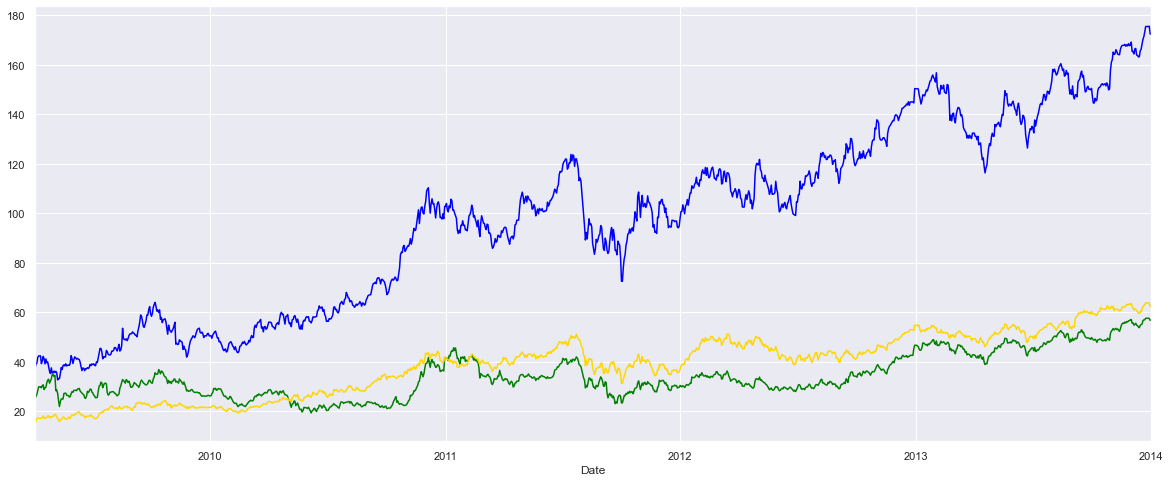

In [10]:
df['vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['por'][start_date:end_date].plot(color = "green")
df['bmw'][start_date:end_date].plot(color = "gold")
plt.show()

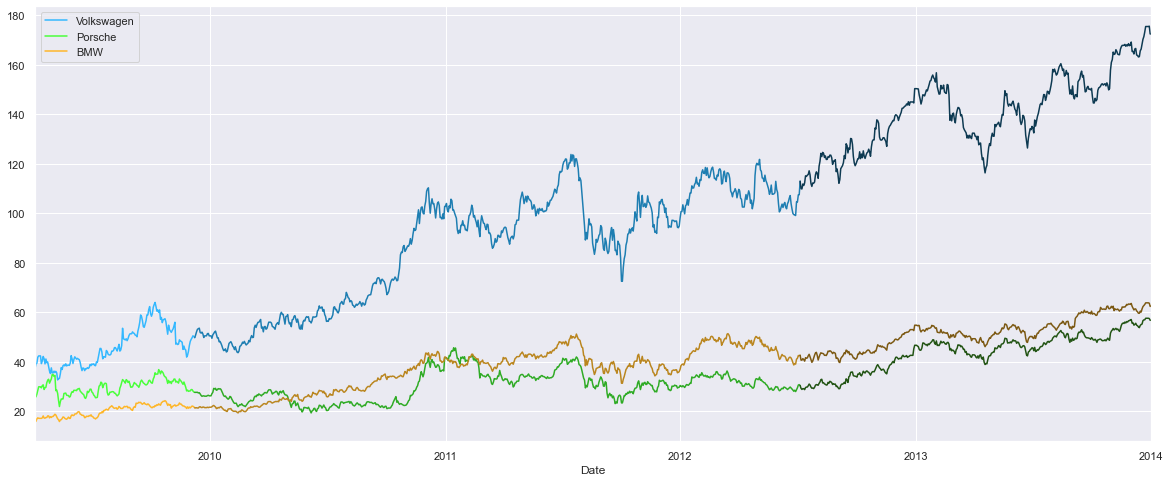

In [11]:
df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

## Correlation Analysis

In [12]:
print('Correlation before Buyout among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation before Buyout among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359547164164515
Volkswagen and BMW correlation: 	0.9799378249373734
Porsche and BMW correlation: 		0.805215791691193


In [13]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633584449543652
Volkswagen and BMW correlation: 	0.8427607817493329
Porsche and BMW correlation: 		0.6095038934500048


Interpretation of low correlation of Porsche and Volkswagen suggests: the equity prices were not similar before the buyout

In [14]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428267849870894
Volkswagen and BMW correlation: 	0.9795942977599614
Porsche and BMW correlation: 		0.704272307871663


In [15]:
print('Correlation after Buyout among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation after Buyout among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237174785847
Volkswagen and BMW correlation: 	0.9284447310955933
Porsche and BMW correlation: 		0.9494111736594023


In [16]:
print('Correlation after Diesel Gate Scandal among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation after Diesel Gate Scandal among manufacturers from 2014-01-01 to 2021-03-18 00:00:00

Volkswagen and Porsche correlation: 	0.9633511890506571
Volkswagen and BMW correlation: 	0.5389378379612183
Porsche and BMW correlation: 		0.5171650061734845


## Modeling 

#### Here we will use the auto ARIMA to select the best fitting ARIMA and SARIMAX models

### for Volkswagen

In [17]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [18]:
# best model before the announcement
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -327.180
Date:                Thu, 18 Mar 2021   AIC                            664.360
Time:                        19:22:07   BIC                            680.269
Sample:                    04-06-2009   HQIC                           670.811
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7404      0.458      1.618      0.106      -0.157       1.637
por            0.3997      0.096      4.169      0.000       0.212       0.588
bmw            0.6763      0.321      2.107      0.035       0.047       1.305
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         2.2785      0.155     14.718      0.000       1.975       2.582
===================================================================================
Ljung-Box (Q):                       38.25   Jarque-Bera (JB):               166.03
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# best model after the announcement
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1095.854
Date:                Thu, 18 Mar 2021   AIC                           2197.708
Time:                        19:22:07   BIC                           2211.234
Sample:                    12-09-2009   HQIC                          2202.947
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7903      0.062     12.842      0.000       0.670       0.911
bmw            1.5139      0.071     21.269      0.000       1.374       1.653
sigma2         1.5349      0.063     24.532      0.000       1.412       1.658
===================================================================================
Ljung-Box (Q):                       33.75   Jarque-Bera (JB):               112.42
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# after the diesel gate announcement
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -616.936
Date:                Thu, 18 Mar 2021   AIC                           1239.872
Time:                        19:22:07   BIC                           1251.762
Sample:                    07-05-2012   HQIC                          1244.586
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7180      0.057     30.369      0.000       1.607       1.829
bmw            0.8382      0.089      9.381      0.000       0.663       1.013
sigma2         1.3966      0.068     20.461      0.000       1.263       1.530
===================================================================================
Ljung-Box (Q):                       28.07   Jarque-Bera (JB):               103.79
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### for Porsche

In [21]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [22]:
# model before the announcement
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -230.105
Date:                Thu, 18 Mar 2021   AIC                            472.209
Time:                        19:22:31   BIC                            491.300
Sample:                    04-06-2009   HQIC                           479.951
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5897      0.385      1.533      0.125      -0.164       1.344
vol            0.1151      0.053      2.157      0.031       0.011       0.220
bmw            0.8626      0.155      5.557      0.000       0.558       1.167
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7682      0.054     14.098      0.000       0.661       0.875
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.36
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# after the announcement
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -597.160
Date:                Thu, 18 Mar 2021   AIC                           1204.319
Time:                        19:22:31   BIC                           1226.863
Sample:                    12-09-2009   HQIC                          1213.051
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1786      0.016     11.134      0.000       0.147       0.210
bmw            0.3244      0.045      7.200      0.000       0.236       0.413
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3471      0.011     32.416      0.000       0.326       0.368
===================================================================================
Ljung-Box (Q):                       33.43   Jarque-Bera (JB):              1076.50
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -219.646
Date:                             Thu, 18 Mar 2021   AIC                            447.292
Time:                                     19:22:31   BIC                            463.146
Sample:                                 07-05-2012   HQIC                           453.577
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2220      0.013     16.876      0.000       0.196       0.248
bmw            0.2450      0.041      6.036      0.000       0.165       0.325
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1811      0.007     27.851      0.000       0.168       0.194
===================================================================================
Ljung-Box (Q):                       34.49   Jarque-Bera (JB):               613.59
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions

#### In this section, we will take the best fitting models and project them into the future

### for Porsche

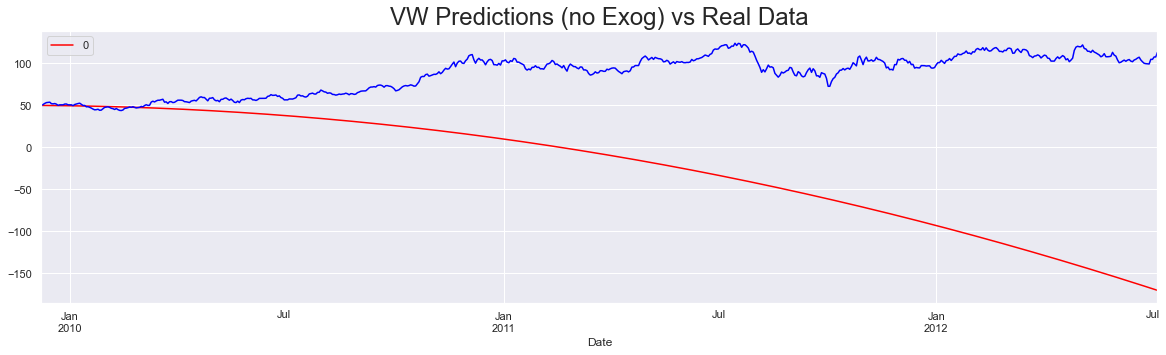

In [25]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

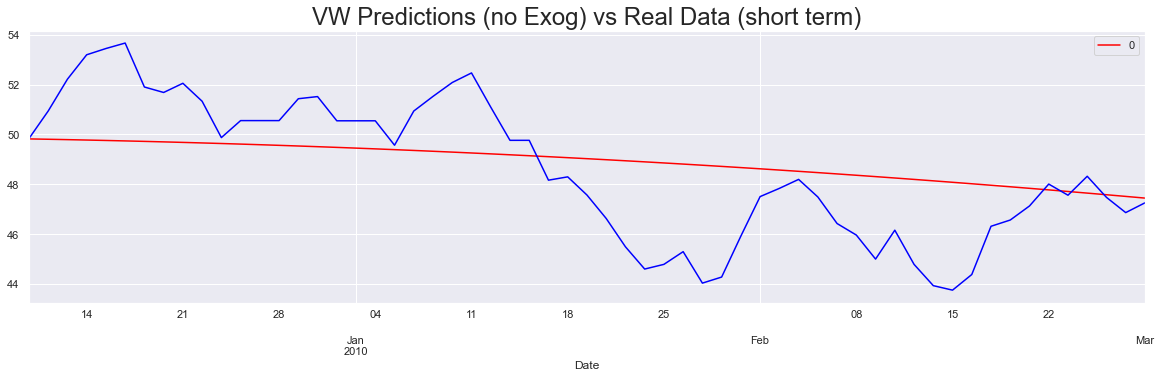

In [26]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

### for Volkswagen

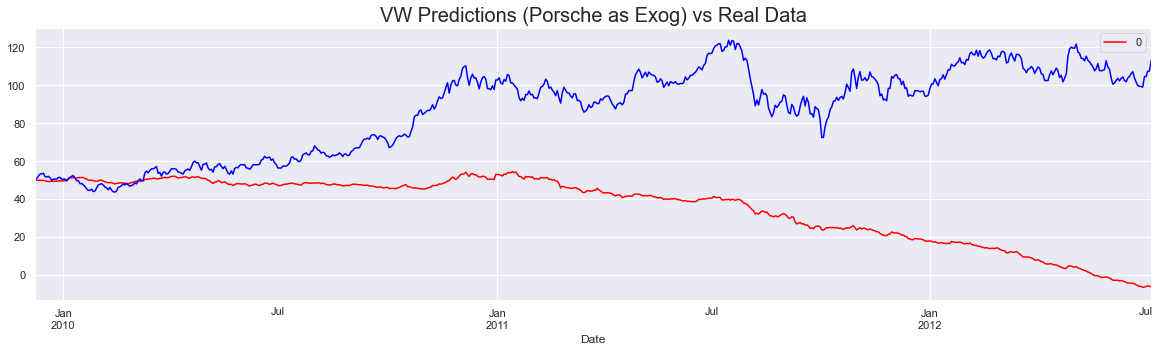

In [27]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], 
                                exogenous = df[['por']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),
                                                          exogenous = df[['por']][ann_1:ann_2]),
                                                          index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 20)
plt.show()

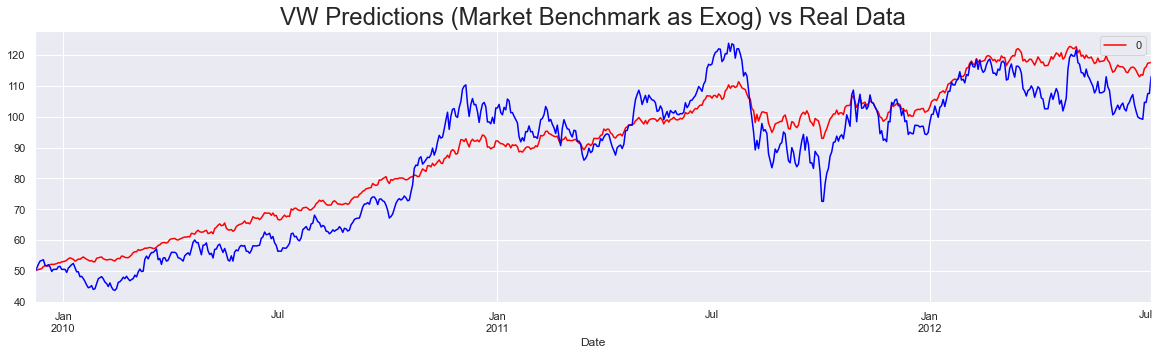

In [28]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], 
                                exogenous = df[['bmw']][start_date:ann_1],
                                m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")
df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), 
                                                          exogenous = df[['bmw']][ann_1:ann_2]),
                                                          index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

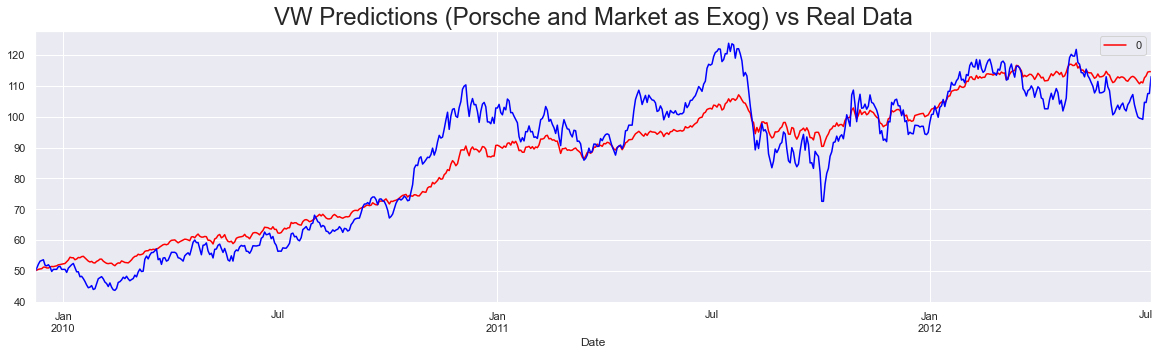

In [29]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), 
                                                          exogenous = df[['por','bmw']][ann_1:ann_2]),
                                                          index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

## Volatility Analysis

### Volatility of VW for the periods surrounding the announcements

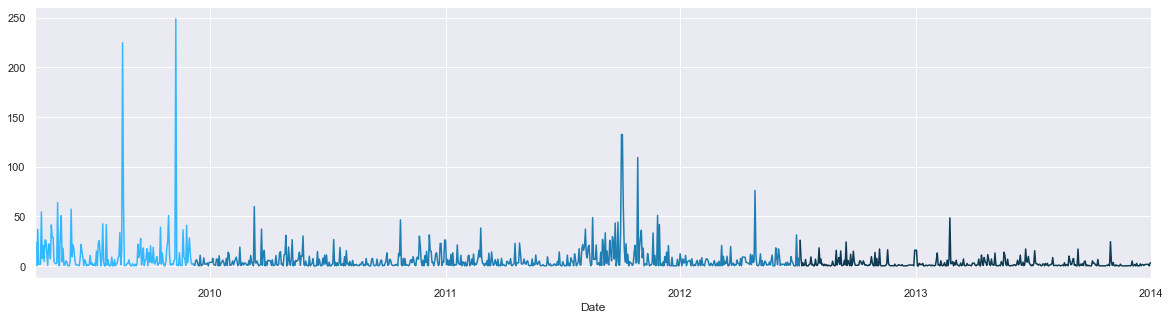

In [30]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatility Trends for the periods surrounding the announcements

In [31]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7775372006258
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.00317765057133
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.9905156457213
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.9905155934316
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7536027362708
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7316714623628
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.731671461118
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.562479494436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5581359856075
            Iterations: 7
            Fu

In [32]:
# before the announcement
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Thu, Mar 18 2021   Df Residuals:                      174
Time:                        19:22:47   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.194e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    6.7760e-14      0.349  1.940e-13      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [33]:
# after the announcement
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Thu, Mar 18 2021   Df Residuals:                      668
Time:                        19:22:47   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.884      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [34]:
# post assessment of volatility
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Thu, Mar 18 2021   Df Residuals:                      386
Time:                        19:22:47   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""